# Stock Prediction Model

## Dependencies

### Library Installation (if needed)

In [102]:
#! pip install yfinance pandas numpy matplotlib lightgbm torch tensorflow keras

### Importing Required Libraries

In [103]:
from datetime import datetime
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
import pickle
import gradio as gr
import ast
from tqdm import tqdm
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

### Variables

In [104]:
build_new_dataset = {'True': True, 'False': False}.get(input('Build New Dataset? (Bool)'))
if build_new_dataset:
    symbol_list = input("Symbols: ('simple', 'filtered' or 'all')") # 'simple' or 'all'. simple are the tickers from the screener notebook and all are all of the tickers in 'filtered_tickers'. You may also an 'Int' to get a % amount of random tickers from 'all'
else:
    symbol_list = 'filtered'

train_new_model = {'True': True, 'False': False}.get(input('Train New Model? (Bool)'))
if train_new_model:
    minimum_feature_threshold = 0.9
    hidden_layers = ast.literal_eval(f"({input('Hidden Layers: eg. "100, 100"')})")
    verticle_jobs = 1 #'-1' for max

if build_new_dataset or train_new_model:
    debugging = {'True': True, 'False': False}.get(input('Debug? (Bool)'))
else:
    debugging = False

## Data Preparation

In [105]:
symbols = []
if symbol_list == 'filtered':
    symbols = pd.read_csv('../data/filtered_tickers.csv')['Ticker'].tolist()
elif symbol_list == 'all':
    symbols = pd.read_csv('../data/tickers.csv')['Ticker'].tolist()
elif symbol_list.isdigit():
    all_symbols = pd.read_csv('../data/tickers.csv')['Ticker'].tolist()
    num_symbols = max(1, round(len(all_symbols) * (int(symbol_list) / 100)))  
    symbols = np.random.choice(all_symbols, num_symbols, replace=False).tolist()
    symbols = symbols + pd.read_csv("../data/filtered_tickers.csv")["Ticker"].tolist()

symbols = symbols + pd.read_csv('../data/simple_screener_results.csv')['Ticker'].tolist()

symbols = pd.Series(symbols).unique()
symbols

array(['LLY', 'PAYX', 'FORD', 'LMAT', 'BSX', 'DXYN', 'BUR', 'LRN', 'FRME',
       'UGI', 'INTC', 'ARWR', 'AXGN', 'SBRA', 'ERIC', 'RNA', 'FCAP',
       'AIZ', 'MMLP', 'BRO', 'MTW', 'BMRN', 'TXN', 'DKS', 'HAS', 'FULT',
       'TLK', 'IPAR', 'FFIN', 'IOSP', 'CIG', 'BDN', 'CE', 'GOGO', 'PWOD',
       'CMC', 'HEES', 'CMLS', 'MBWM', 'SJM', 'EQR', 'BCRX', 'NEE', 'SD',
       'FR', 'BELFB', 'BYD', 'AVB', 'AMWD', 'SON', 'JBHT', 'EXK', 'HTBK',
       'PPBI', 'GD', 'KGC', 'TTMI', 'GURE', 'RGP', 'COKE', 'ALE', 'RBC',
       'RGLD', 'HWBK', 'HIG', 'DCO', 'LSTR', 'ESS', 'CSX', 'BRT', 'LKFN',
       'TRNS', 'LINC', 'SHW', 'CTS', 'RCKY', 'YELP', 'YORW', 'TRGP',
       'BXP', 'FSS', 'CFR', 'STRA', 'FCBC', 'BCE', 'TBBK', 'PSIX', 'TDG',
       'BLMN', 'ASML', 'AVT', 'FTNT', 'AIN', 'UNH', 'ELA', 'WDC', 'FCEL',
       'DIN', 'SIEB', 'WOOF', 'WAB', 'WASH', 'DSX', 'CLRO', 'RM', 'BLKB',
       'HOV', 'PFBX', 'PBYI', 'LNT', 'MITT', 'CRUS', 'CVI', 'LND', 'OGE',
       'OXM', 'VECO', 'IVR', 'GVA', 'AXP', 'ASH', 

#### Download annual financial data

In [106]:
if build_new_dataset:
    df = pd.DataFrame()
    filtered_pd = pd.read_csv('../data/filtered_tickers.csv')
    for symbol in tqdm(symbols):
        ticker_df = pd.DataFrame()
        ticker = yf.Ticker(symbol)
        try:
            # Latest earning data
            latest_earning_date = ticker.quarterly_cash_flow.columns.tolist()[0]
            latest_data = {'Ticker': symbol, 'Date': latest_earning_date}
            latest_data['3M Future Change'] = np.nan
            latest_data['6M Future Change'] = np.nan
            latest_data['1Y Future Change'] = np.nan
            try:
                latest_data['Sector'] = ticker.info['sector']
            except:
                latest_data['Sector'] = 'Unknown'
            try:
                latest_data['Industry'] = ticker.info['industry']
            except:
                latest_data['Industry'] = 'Unknown'
            for column in ticker.quarterly_cash_flow[latest_earning_date].keys().tolist():
                latest_data[column] = ticker.quarterly_cash_flow[latest_earning_date][column]
            for column in ticker.quarterly_balance_sheet[latest_earning_date].keys().tolist():
                latest_data[column] = ticker.quarterly_balance_sheet[latest_earning_date][column]
            for column in ticker.quarterly_income_stmt[latest_earning_date].keys().tolist():
                latest_data[column] = ticker.quarterly_income_stmt[latest_earning_date][column]
            ticker_df = pd.concat([ticker_df, pd.DataFrame([latest_data])], ignore_index=True)

            # Annual data
            earning_dates = ticker.cash_flow.columns.tolist()
            price_data = yf.download(symbol, period='10y', rounding=False, progress=False)
            cash_flow = ticker.cash_flow
            cash_flow_columns = cash_flow[earning_dates[0]].keys().tolist()
            balance_sheet = ticker.balance_sheet
            balance_sheet_columns = balance_sheet[earning_dates[0]].keys().tolist()
            income_statement = ticker.income_stmt
            income_statement_columns = income_statement[earning_dates[0]].keys().tolist()
            for earning_date in earning_dates:
                earning_date_data = {'Ticker': symbol, 'Date': earning_date}
                got_price = False
                day_offset = 0
                while(got_price==False and day_offset > -6):
                    try:           
                        earning_date_data['3M Future Change'] = (
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset, weeks=13) , ('Close', symbol)]) / 
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset), ('Close', symbol)]) - 1
                        )
                        earning_date_data['6M Future Change'] = (
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset, weeks=26) , ('Close', symbol)]) / 
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset), ('Close', symbol)]) - 1
                        )
                        earning_date_data['1Y Future Change'] = (
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset, weeks=52) , ('Close', symbol)]) / 
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset), ('Close', symbol)]) - 1
                        )
                        got_price = True
                    except:
                        day_offset += -1
                try:
                    earning_date_data['Sector'] = ticker.info['sector']
                except:
                    earning_date_data['Sector'] = 'Unknown'
                try:
                    earning_date_data['Industry'] = ticker.info['industry']
                except:
                    earning_date_data['Industry'] = 'Unknown'
                for column in cash_flow_columns:
                    earning_date_data[column] = cash_flow[earning_date][column]
                for column in balance_sheet_columns:
                    earning_date_data[column] = balance_sheet[earning_date][column]
                for column in income_statement_columns:
                    earning_date_data[column] = income_statement[earning_date][column]
                if got_price:
                    ticker_df = pd.concat([ticker_df, pd.DataFrame([earning_date_data])], ignore_index=True)

            if len(ticker_df) == 5 and ticker_df.isna().sum().sum() < round(352 * minimum_feature_threshold):
                if symbol not in filtered_pd['Ticker'].tolist():
                    filtered_pd = pd.concat([filtered_pd, pd.DataFrame([{'Ticker': symbol}])])
                imputer = SimpleImputer()
                for column in ticker_df.columns.drop(['Ticker', 'Date', '3M Future Change', '6M Future Change', '1Y Future Change', 'Sector', 'Industry']):
                    if not ticker_df[column].isna().all():
                        ticker_df[column] = imputer.fit_transform(ticker_df[[column]])
            else:
                if symbol in filtered_pd['Ticker'].tolist():
                    filtered_pd = filtered_pd[filtered_pd['Ticker'] != symbol]
                    if debugging:
                        print(f'Removed {symbol} from filtered tickers. Datapoints: {ticker_df.isna().sum().sum()}, Needed: {round(352 * minimum_feature_threshold)}')
                continue
            df = pd.concat([df, ticker_df], ignore_index=True)
        except Exception as error:
            if symbol in filtered_pd['Ticker'].tolist():
                filtered_pd = filtered_pd[filtered_pd['Ticker'] != symbol]
                if debugging:
                    print(f'Removed {symbol} from filtered tickers because an exception was raised')
            continue
    filtered_pd.to_csv('../data/filtered_tickers.csv', index=False)
    df.to_csv('../data/earnings_data.csv', index=False)
else:
    df = pd.read_csv('../data/earnings_data.csv')

### Short visualisation

In [107]:
if debugging:
    df

### Impution and encoding

In [108]:
imputer = SimpleImputer()
scaler = StandardScaler()
for column in df.columns.drop(['Ticker', 'Date', '3M Future Change', '6M Future Change', '1Y Future Change', 'Sector', 'Industry']):
    df[column] = imputer.fit_transform(df[[column]])
    scaler.fit(df[[column]])
    df[column] = scaler.transform(df[[column]])

le = LabelEncoder()
for column in ['Ticker', 'Sector', 'Industry']:
    df[column] = df[column].astype(str)
    le.fit(df[column])
    df[column] = le.transform(df[column])

### Splitting

In [109]:
pred_data = pd.DataFrame()
for i in range(int(len(df) / 5)):
    pred_data = pd.concat([pred_data, df.iloc[[i*5]]]) 
if debugging:
    print('Prediction Data:')
    display(pred_data)

train_data = pd.DataFrame()
for i in range(int(len(df) / 5)):
    train_data = pd.concat([train_data, df.iloc[[1+i*5]]])
    train_data = pd.concat([train_data, df.iloc[[2+i*5]]])
    train_data = pd.concat([train_data, df.iloc[[3+i*5]]])
    train_data = pd.concat([train_data, df.iloc[[4+i*5]]])
if debugging:
    print('Train and Test Data:')
    display(train_data)

### Labeling

In [110]:
X_pred = pred_data.drop(['Date', '3M Future Change', '6M Future Change', '1Y Future Change'], axis=1)
X_train = train_data.drop(['Date', '3M Future Change', '6M Future Change', '1Y Future Change'], axis=1)
y_train = train_data[['3M Future Change', '6M Future Change', '1Y Future Change']]

X_train, X_test, y_train, y_test = train_test_split(
    X_train,
    y_train,
    test_size=0.15,
    shuffle=True,
)

if debugging:
    display(X_train)
    display(y_train)
    display(X_test)
    display(y_test)

## Model Training

In [111]:
if train_new_model:
    model = MLPRegressor(
        hidden_layer_sizes=hidden_layers,
        learning_rate="adaptive",
        early_stopping=True,
        verbose=True,
        n_iter_no_change=10
    )
    model.fit(X_train, y_train)

Iteration 1, loss = 6013.36722342
Validation score: -254.878145
Iteration 2, loss = 22.08798799
Validation score: -383.567720
Iteration 3, loss = 2.92623389
Validation score: -30.404557
Iteration 4, loss = 0.58115090
Validation score: -7.409503
Iteration 5, loss = 0.30141702
Validation score: -0.897414
Iteration 6, loss = 0.24985386
Validation score: -1.328841
Iteration 7, loss = 0.19795338
Validation score: -0.227085
Iteration 8, loss = 0.15208470
Validation score: -0.284701
Iteration 9, loss = 0.14960445
Validation score: -0.177687
Iteration 10, loss = 0.19284167
Validation score: -0.343024
Iteration 11, loss = 0.20704044
Validation score: -1.303889
Iteration 12, loss = 0.23979530
Validation score: -0.088317
Iteration 13, loss = 0.18462824
Validation score: -0.072781
Iteration 14, loss = 0.15640911
Validation score: -0.266910
Iteration 15, loss = 0.17227834
Validation score: -0.336766
Iteration 16, loss = 0.29199989
Validation score: -0.891148
Iteration 17, loss = 0.18409422
Validati

## Testing and benchmarking

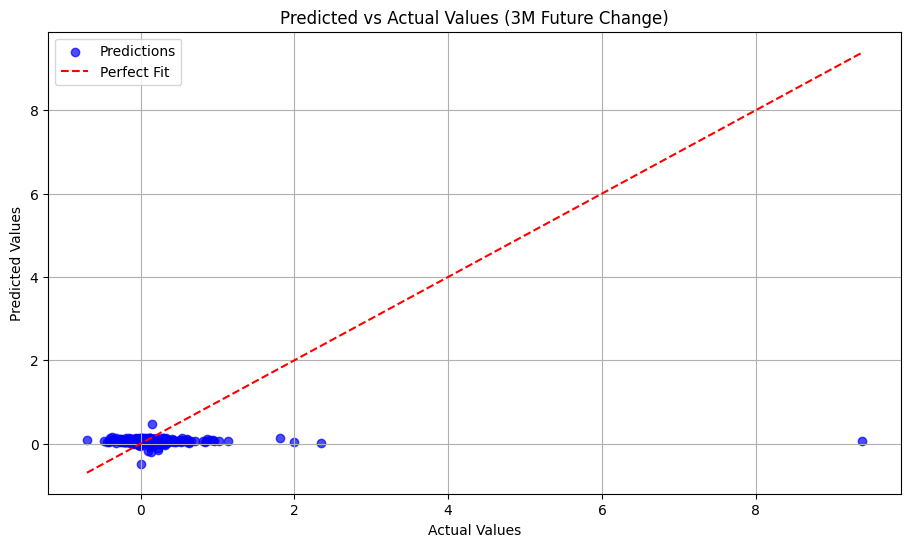

3M Future Change - R²: -0.0164
3M Future Change - MSE: 0.2569
3M Future Change - MAE: 0.1969


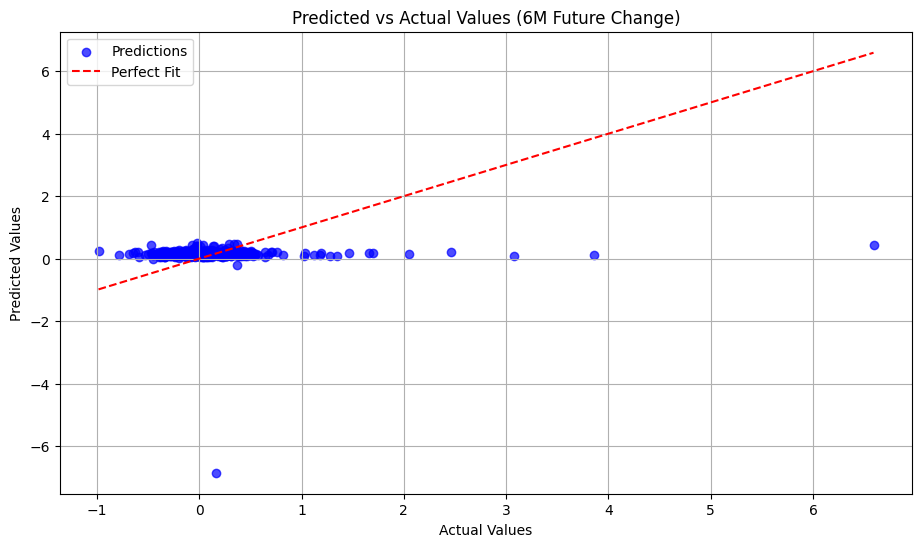

6M Future Change - R²: -0.4153
6M Future Change - MSE: 0.3577
6M Future Change - MAE: 0.3027


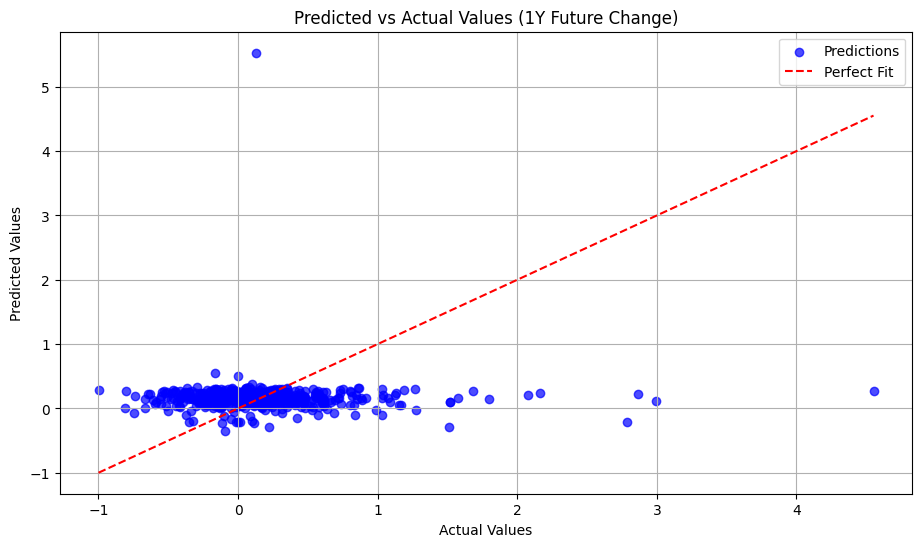

1Y Future Change - R²: -0.2841
1Y Future Change - MSE: 0.3471
1Y Future Change - MAE: 0.3695

Overall Scores:
Mean - R²: -0.2386
Mean - MSE: 0.3206
Mean - MAE: 0.2897


In [112]:
if train_new_model:
    y_test_pred = model.predict(X_test)

    for i, target in enumerate(['3M Future Change', '6M Future Change', '1Y Future Change']):
        y_test_actual = y_test[target]
        y_test_pred_target = y_test_pred[:, i]

        plt.figure(figsize=(11, 6))
        plt.scatter(y_test_actual, y_test_pred_target, alpha=0.7, color='blue', label='Predictions')
        plt.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], 
            color='red', linestyle='--', label='Perfect Fit')
        plt.title(f'Predicted vs Actual Values ({target})')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.legend()
        plt.grid(True)
        plt.show()

        mae = mean_absolute_error(y_test_actual, y_test_pred_target)
        mse = mean_squared_error(y_test_actual, y_test_pred_target)
        r2 = r2_score(y_test_actual, y_test_pred_target)

        print(f'{target} - R²: {r2:.4f}')
        print(f'{target} - MSE: {mse:.4f}')
        print(f'{target} - MAE: {mae:.4f}')

    mae = mean_absolute_error(y_test, y_test_pred)
    mse = mean_squared_error(y_test, y_test_pred)
    r2 = r2_score(y_test, y_test_pred)

    print('\nOverall Scores:')
    print(f'Mean - R²: {r2:.4f}')
    print(f'Mean - MSE: {mse:.4f}')
    print(f'Mean - MAE: {mae:.4f}')

### Log test results

In [113]:
if train_new_model:
    test_results = pd.DataFrame({
        'R²': r2,
        'MSE': mse,
        'MAE': mae,
        'symbol_list': symbol_list,
        'hidden_layer_sizes': [model.hidden_layer_sizes],
        'max_iter': model.max_iter,
        'n_iter_no_change': model.n_iter_no_change,
        'learning_rate': model.learning_rate,
        'learning_rate_init': model.learning_rate_init,
        'batch_size': model.batch_size,
        'tol': model.tol,
        'alpha': model.alpha,
        'shuffle': model.shuffle,
    })
    test_results.to_csv('../data/test_results.csv', mode='a', index=False)

    # save model as new best if results are better than the current one
    best_r2 = pd.read_csv('../models/best_model_results.csv').loc[0, 'R²']
    if r2 > best_r2:
        print(f'Old best R²: {best_r2}')
        print(f'New best R²: {r2}')
        print('Saving new best model...')
        test_results.to_csv('../models/best_model_results.csv', mode='w', index=False)
        with open('../models/best_model.pkl','wb') as f:
            pickle.dump(model,f)
        

Old best R²: -0.2907740416737683
New best R²: -0.2386041650746659
Saving new best model...


## Predictions on latest data

In [114]:
best_r2 = pd.read_csv('../models/best_model_results.csv').loc[0, 'R²']

with open('../models/best_model.pkl', 'rb') as f:
    model = pickle.load(f)
    print(f'Best model R²: {best_r2}')


Best model R²: -0.2386041650746659


In [115]:
df_raw = pd.read_csv('../data/earnings_data.csv')

results = []
for i in range(len(X_pred)):
    y_pred = model.predict(X_pred.iloc[[i]])[0]
    y_pred_3m, y_pred_6m, y_pred_1y = y_pred
    avg = (y_pred_3m + y_pred_6m + y_pred_1y) / 3
    results.append({
        'Ticker': df_raw.loc[i*5, 'Ticker'],
        'mean (%)': avg * 100,
        '3m (%)': y_pred_3m * 100,
        '6m (%)': y_pred_6m * 100,
        '1y (%)': y_pred_1y * 100
    })

results_df = pd.DataFrame(results)
results_df

,Ticker,mean (%),3m (%),6m (%),1y (%)
0,BIOF,13.124393,16.347860,21.207966,1.817354
1,LKQ,11.243066,5.738638,12.095499,15.895062
2,GENC,10.365597,6.338535,12.563218,12.195038
3,FDX,8.270338,3.206795,10.642069,10.962149
4,MKSI,14.768305,7.273062,19.444195,17.587659
...,...,...,...,...,...
802,PKE,13.641665,6.494288,14.269881,20.160826
803,CBAN,5.654889,5.085023,6.624051,5.255594
804,FOSL,9.921450,5.528296,11.252383,12.983671
805,DSX,11.952424,6.775722,15.896574,13.184977


In [116]:
def predict_ticker(ticker_str):
    try:
        ticker_str = str(ticker_str).upper()
        ticker_str = ticker_str.replace("'", "")
        ticker_str = ticker_str.replace('"', "")
        row = results_df[results_df['Ticker'] == ticker_str]
        if row.empty:
            return (f"The author was stupid and forgot to cover this obvious, famous stock. Try another.", "", "", "")
        row = row.iloc[0]
        return (
            f"{row['3m (%)']:.2f}",
            f"{row['6m (%)']:.2f}",
            f"{row['1y (%)']:.2f}",
            f"{row['mean (%)']:.2f}",
        )
    except Exception as e:
        return (f"Error: {e}", "", "", "")

In [117]:
iface = gr.Interface(
    fn=predict_ticker,
    inputs=gr.Textbox(label="Ticker (e.g. 'TSLA' or 'MATAS.CO')"),
    outputs=[
        gr.Textbox(label="3 Month Change Prediction (%)"),
        gr.Textbox(label="6 Month Change Prediction (%)"),
        gr.Textbox(label="1 Year Change Prediction (%)"),
        gr.Textbox(label="Mean Change Prediction (%)"),
    ],
    title="Stock Price Prediction Model",
    description=" "
)

iface.launch(share=True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://61172e97ecb196af91.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
